In [176]:
# Base Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Train/ Test Split
from sklearn.model_selection import train_test_split

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# Estimators
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import GradientBoostingClassifier

# Hyper Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Metrics and Evaluation
from sklearn.metrics import accuracy_score, classification_report





In [177]:
RUN_GRID_SEARCH = False

In [178]:
conn = sqlite3.connect('../../../../data/FPA_FOD_20170508.sqlite')

In [179]:
%%time
df_fires = pd.read_sql_query("SELECT * FROM 'Fires'", conn)
# df_fires = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)


Wall time: 35.9 s


## Data Quality

In [180]:
df_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

In [181]:
df_fires.iloc[0]

OBJECTID                                                                      1
FOD_ID                                                                        1
FPA_ID                                                               FS-1418826
SOURCE_SYSTEM_TYPE                                                          FED
SOURCE_SYSTEM                                                       FS-FIRESTAT
NWCG_REPORTING_AGENCY                                                        FS
NWCG_REPORTING_UNIT_ID                                                  USCAPNF
NWCG_REPORTING_UNIT_NAME                                 Plumas National Forest
SOURCE_REPORTING_UNIT                                                      0511
SOURCE_REPORTING_UNIT_NAME                               Plumas National Forest
LOCAL_FIRE_REPORT_ID                                                          1
LOCAL_INCIDENT_ID                                                        PNF-47
FIRE_CODE                               

In [182]:
df_fires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Set Index

In [183]:
%%time
df_fires.set_index("OBJECTID", inplace=True)

Wall time: 17 ms


In [184]:
df_fires.index.is_unique

True

### Missing Values

In [185]:
df_fires.isna().any()

FOD_ID                        False
FPA_ID                        False
SOURCE_SYSTEM_TYPE            False
SOURCE_SYSTEM                 False
NWCG_REPORTING_AGENCY         False
NWCG_REPORTING_UNIT_ID        False
NWCG_REPORTING_UNIT_NAME      False
SOURCE_REPORTING_UNIT         False
SOURCE_REPORTING_UNIT_NAME    False
LOCAL_FIRE_REPORT_ID           True
LOCAL_INCIDENT_ID              True
FIRE_CODE                      True
FIRE_NAME                      True
ICS_209_INCIDENT_NUMBER        True
ICS_209_NAME                   True
MTBS_ID                        True
MTBS_FIRE_NAME                 True
COMPLEX_NAME                   True
FIRE_YEAR                     False
DISCOVERY_DATE                False
DISCOVERY_DOY                 False
DISCOVERY_TIME                 True
STAT_CAUSE_CODE               False
STAT_CAUSE_DESCR              False
CONT_DATE                      True
CONT_DOY                       True
CONT_TIME                      True
FIRE_SIZE                   

In [186]:
df_fires.shape[0]

1880465

### Duplicate Rows

In [187]:
df_fires.duplicated().any()

False

In [188]:
plt.style.use('ggplot')

### Causes of Wildfires

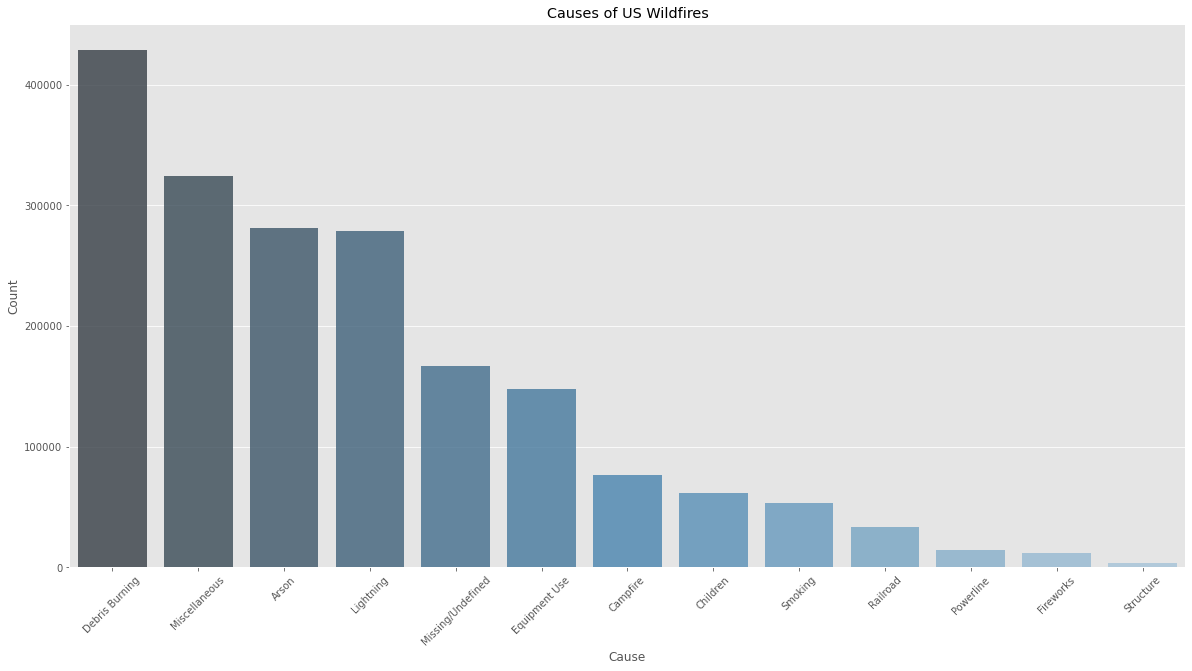

In [189]:
fig_0 = plt.figure(1, figsize=(20, 10))

chart_1 = fig_0.add_subplot(111)

cause_count  = df_fires['STAT_CAUSE_DESCR'].value_counts()

# sns.countplot(x="STAT_CAUSE_DESCR", data=df_fires, ax=chart_1, palette="Blues_d")
sns.barplot(cause_count.index, cause_count.values, alpha=0.8, palette="Blues_d")
chart_1.set_title('Causes of US Wildfires')
chart_1.set_xlabel('Cause')
chart_1.set_ylabel('Count')
chart_1.set_xticklabels(chart_1.get_xticklabels(), rotation=45)

# plt.savefig('C:\\Users\\Chance\\Desktop\\us_wilfire_causes.png')

plt.show()

In [190]:
# df_fires.head().to_csv("../../../../data/FPA_FOD_20170508_SAMPLE.CSV", index=False)

### Converting Julian to calendar date using pandas

 - https://stackoverflow.com/questions/63434276/converting-julian-to-calendar-date-using-pandas

In [191]:
%%time
df_fires["DISCOVERY_DATETIME"] = pd.to_datetime(df_fires["DISCOVERY_DATE"], unit='D', origin='julian')


Wall time: 174 ms


In [192]:
df_fires["DISCOVERY_DATETIME"].head()

OBJECTID
1   2005-02-02
2   2004-05-12
3   2004-05-31
4   2004-06-28
5   2004-06-28
Name: DISCOVERY_DATETIME, dtype: datetime64[ns]

In [193]:
df_fires["DISCOVERY_TIME"].head()

OBJECTID
1    1300
2    0845
3    1921
4    1600
5    1600
Name: DISCOVERY_TIME, dtype: object

In [194]:
df_fires['DISCOVERY_DAY_OF_WEEK'] = df_fires["DISCOVERY_DATETIME"].dt.day_name()

### Annual Count of US Wildfires


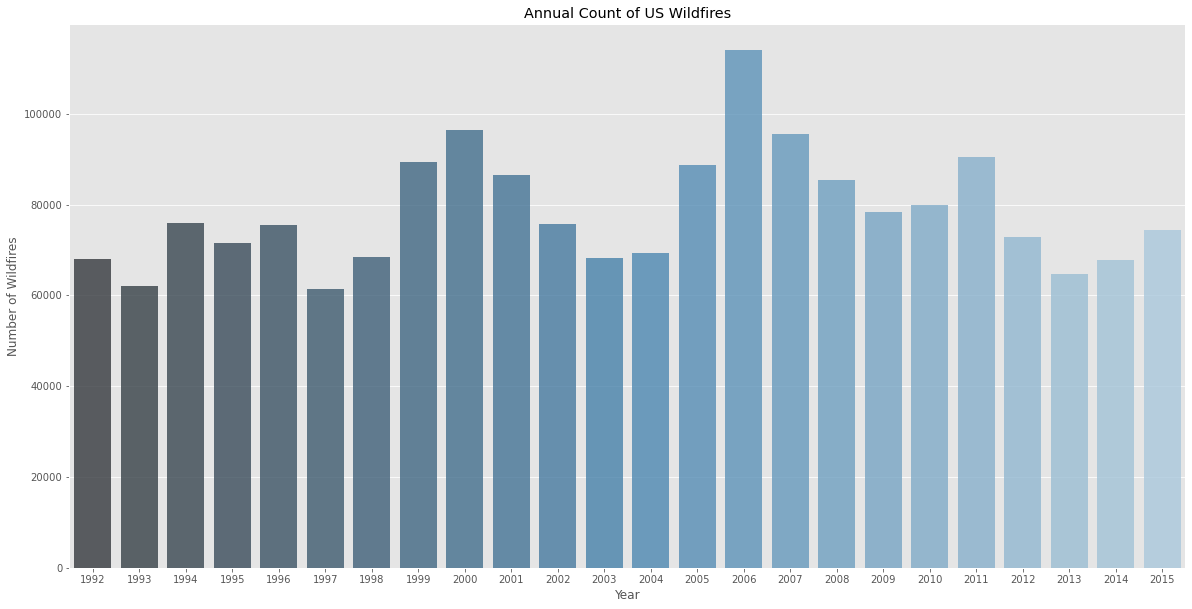

In [195]:

year_count  = df_fires['FIRE_YEAR'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
sns.barplot(year_count.index, year_count.values, alpha=0.8, palette="Blues_d")
plt.title('Annual Count of US Wildfires')
plt.ylabel('Number of Wildfires')
plt.xlabel('Year')


# plt.savefig('C:\\Users\\Chance\\Desktop\\us_wilfires_by_year.png')


plt.show()

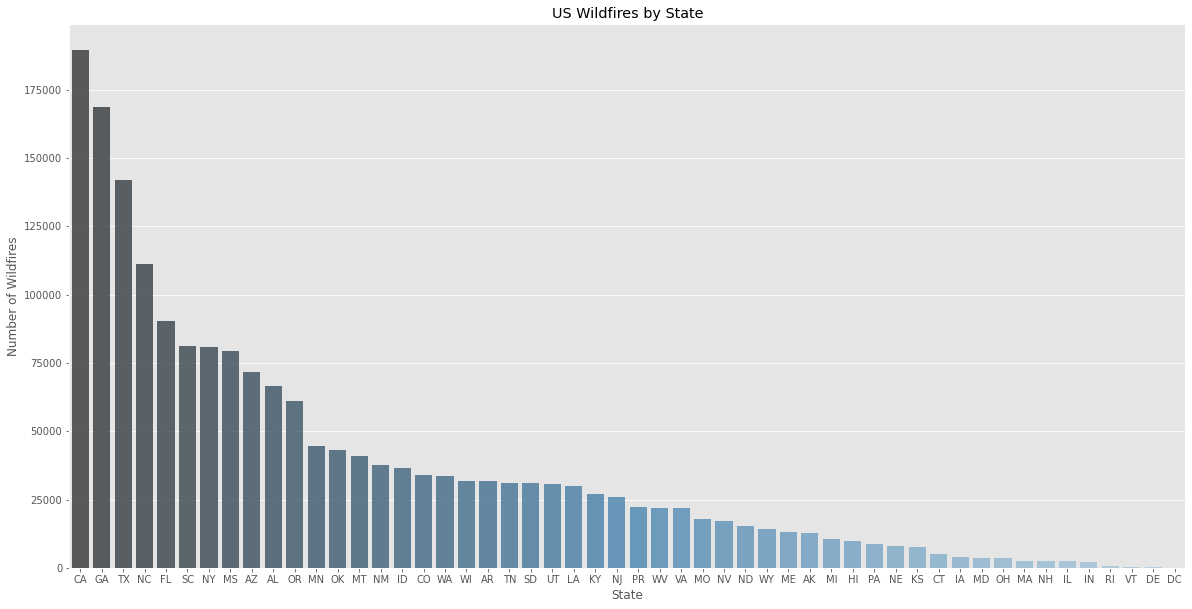

In [196]:
state_count  = df_fires['STATE'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(state_count.index, state_count.values, alpha=0.8, palette="Blues_d")
plt.title('US Wildfires by State')
plt.ylabel('Number of Wildfires')
plt.xlabel('State')


# plt.savefig('C:\\Users\\Chance\\Desktop\\us_wilfires_by_state.png')


plt.show()

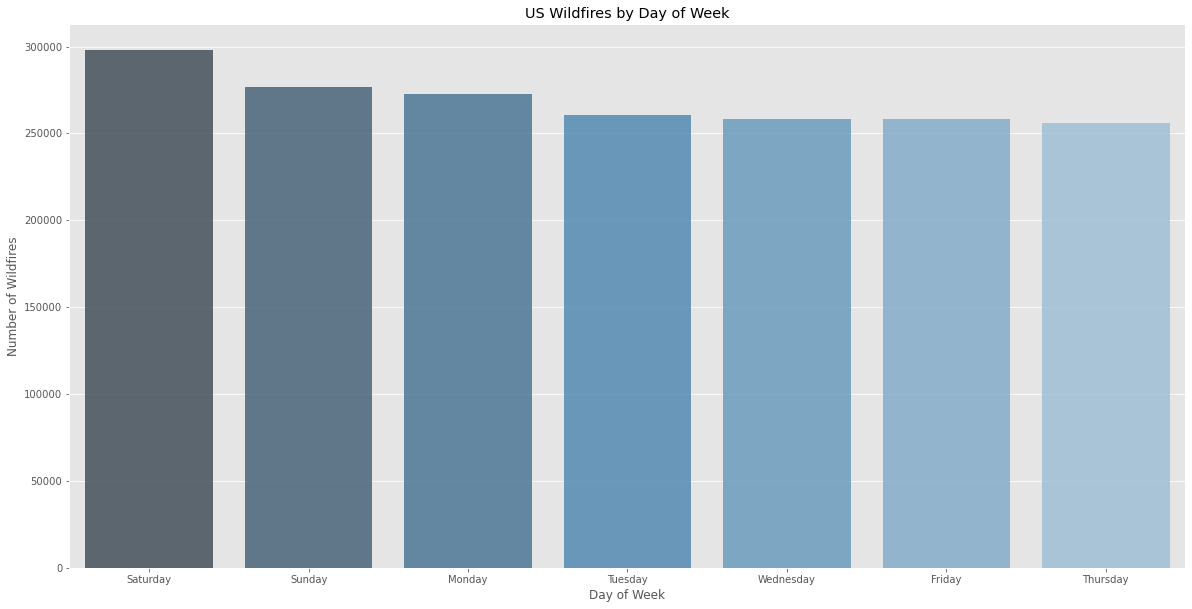

In [197]:
day_of_week_count  = df_fires['DISCOVERY_DAY_OF_WEEK'].value_counts()
plt.figure(figsize=(20, 10))
sns.barplot(day_of_week_count.index, day_of_week_count.values, alpha=0.8, palette="Blues_d")
plt.title('US Wildfires by Day of Week')
plt.ylabel('Number of Wildfires')
plt.xlabel('Day of Week')


# plt.savefig('C:\\Users\\Chance\\Desktop\\us_wilfires_by_state.png')


plt.show()

In [198]:
%%time

X = df_fires[["LATITUDE", "LONGITUDE", "DISCOVERY_DATE", "FIRE_SIZE", "STATE", "OWNER_DESCR", "DISCOVERY_DAY_OF_WEEK"]]
y = df_fires["STAT_CAUSE_DESCR"]

Wall time: 1.4 s


## Grid Search CV

In [199]:
if (RUN_GRID_SEARCH):
    
    numeric_features = ["LATITUDE", "LONGITUDE", "DISCOVERY_DATE", "FIRE_SIZE"]
    categorical_features = ["STATE", "OWNER_DESCR", "DISCOVERY_DAY_OF_WEEK"]

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])


    clf1 = DecisionTreeClassifier(random_state=1)


    pipe1 = Pipeline([['preprocessor', preprocessor], 
                    ['clf', OneVsRestClassifier(clf1)]])

    model_params = {
        "decisiontreeclassifier": {
            "model": pipe1,
            "params": {
                # "clf__estimator__criterion": ['gini'], # ,'entropy'
                "clf__estimator__splitter": ['random', 'best']
                # "clf__estimator__min_samples_split": [10],
                # "clf__estimator__min_samples_leaf": [4],
                # "clf__estimator__max_features": ['auto'], # , 'sqrt', 'log2'
                #"clf__estimator__class_weight": [None] # , 'balanced'
            }
        }
    }


    scores = []

    for model_name, mp in model_params.items():

        # print(mp["model"].get_params().keys())

        start = time.time()
        clf = RandomizedSearchCV(estimator=mp["model"], param_distributions=mp["params"], cv=2, scoring="accuracy", n_jobs=-1)
        clf.fit(X, y)
        elapsed_time = (time.time() - start)

        scores.append({"Model": model_name,
        "Best Accuracy": clf.best_score_, # Mean cross-validated score of the best_estimator
        "Best Params": clf.best_params_,
        "results": clf.cv_results_,
        "Cross Validation Time": elapsed_time,
        "Best Estimator": clf.best_estimator_
        })

In [200]:
%%time

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# map to numerical values in a new variable
df_fires["STATE_CAT"] = label_encoder.fit_transform(df_fires['STATE'])
df_fires["OWNER_DESCR_CAT"] = label_encoder.fit_transform(df_fires['OWNER_DESCR'])
df_fires["DISCOVERY_DAY_OF_WEEK_CAT"] = label_encoder.fit_transform(df_fires['DISCOVERY_DAY_OF_WEEK'])



Wall time: 1.2 s


In [201]:
%%time

X = df_fires[["LATITUDE", "LONGITUDE", "DISCOVERY_DATE", "FIRE_SIZE", "STATE_CAT", "OWNER_DESCR_CAT", "DISCOVERY_DAY_OF_WEEK_CAT"]]
y = df_fires["STAT_CAUSE_DESCR"]

Wall time: 107 ms


In [202]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)


Wall time: 4.56 s


## Train Decision Classifier


In [203]:
%%time

clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=1, splitter='best', min_samples_split=5, min_samples_leaf=4, max_features='auto', class_weight=None))
clf.fit(X_train, y_train)

Wall time: 1min 42s


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_features='auto',
                                                     min_samples_leaf=4,
                                                     min_samples_split=5,
                                                     random_state=1))

In [204]:
%%time
y_pred = clf.predict(X_test)

Wall time: 803 ms


In [205]:
print ('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.5223640898286067


In [206]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

            Arson       0.51      0.48      0.50     28145
         Campfire       0.39      0.28      0.33      7614
         Children       0.24      0.16      0.19      6117
   Debris Burning       0.51      0.56      0.53     42903
    Equipment Use       0.31      0.27      0.29     14761
        Fireworks       0.37      0.31      0.34      1150
        Lightning       0.70      0.75      0.72     27847
    Miscellaneous       0.47      0.49      0.48     32381
Missing/Undefined       0.88      0.89      0.88     16672
        Powerline       0.15      0.12      0.13      1445
         Railroad       0.40      0.40      0.40      3345
          Smoking       0.13      0.09      0.10      5287
        Structure       0.01      0.07      0.02       380

         accuracy                           0.52    188047
        macro avg       0.39      0.37      0.38    188047
     weighted avg       0.52      0.52      0.52    18